# RGB Synthesis

This notebook explores synthesis of RGB images from hyperspectral data for use as training samples in reconstruction.

In [1]:
import h5py

import numpy as np
import pandas as pd

import scipy.integrate as integrate
import scipy.interpolate as interpolate

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

## Loading a Hyperspectral Image

We start by loading a reference hyperspectral image for use in subsequent experiments.

In [2]:
with h5py.File('datasets/ICVL/BGU_0403-1419-1.mat', 'r') as file:
    hsi = np.array(file['rad']).swapaxes(0, 2)
    hsi_wavelengths = np.squeeze(file['bands'])

In this case, we're using an image from the ICVL dataset, which stores raw sensor data (i.e., uncalibrated radiance).

In [3]:
hsi.min(), hsi.max()

(np.float64(185.125), np.float64(2897.5))

The maximum value used by the sensor in the entire dataset is $2^{12} - 1 = 4095$, which we use for normalization.

In [4]:
hsi /= 4095

Indeed, all samples in the image should now be in range $[0, 1]$.

In [5]:
hsi.min(), hsi.max()

(np.float64(0.04520757020757021), np.float64(0.7075702075702076))

To facilitate reshaping operations, we also extract the dimensions of the image.

In [6]:
height, width, bands = hsi.shape

## Synthesis using Sony IMX219

We load the camera sensitivity curves from the provided CSV file.

In [7]:
imx219_df = pd.read_csv('resources/Sony_IMX219.csv')

The sensitivities data frame consists of RGB and CMY samples at specific wavelengths, with high spectral resolution.

In [8]:
imx219_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3001 entries, 0 to 3000
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Wavelength  3001 non-null   float64
 1   R           3001 non-null   float64
 2   G           3001 non-null   float64
 3   B           3001 non-null   float64
 4   C           3001 non-null   float64
 5   M           3001 non-null   float64
 6   Y           3001 non-null   float64
dtypes: float64(7)
memory usage: 164.2 KB


Originally, the step of the sensitivity curves is 0.2 nanometers.

In [9]:
imx219_df.head()

,Wavelength,R,G,B,C,M,Y
0,300.0,0.010200,0.011000,0.009000,0.020753,0.051105,0.050229
1,300.2,0.010419,0.010980,0.009020,0.020910,0.051702,0.050351
2,300.4,0.010641,0.010961,0.009044,0.021069,0.052299,0.050472
3,300.6,0.010868,0.010943,0.009074,0.021228,0.052894,0.050592
4,300.8,0.011100,0.010926,0.009109,0.021388,0.053488,0.050712


However, to significantly reduce further computation (at comparatively little loss in accuracy), we downsample the steps of all curves to just 1 nanometer per step.

In [10]:
imx219_df = imx219_df.iloc[::5]

In [11]:
imx219_df.head()

,Wavelength,R,G,B,C,M,Y
0,300.0,0.010200,0.011000,0.009000,0.020753,0.051105,0.050229
5,301.0,0.011335,0.010911,0.009148,0.021548,0.054081,0.050832
10,302.0,0.012575,0.010856,0.009422,0.022367,0.057026,0.051425
15,303.0,0.013916,0.010834,0.009819,0.023211,0.059937,0.052010
20,304.0,0.015353,0.010847,0.010337,0.024082,0.062814,0.052588


For convenience, we extract sensitivity curves and wavelengths into numpy arrays.

In [12]:
imx219_wavelengths = imx219_df['Wavelength'].values
imx219_rgb = imx219_df[['R', 'G', 'B']].values
imx219_cmy = imx219_df[['C', 'M', 'Y']].values

As a visual reference, we plot the loaded sensitivity curves.

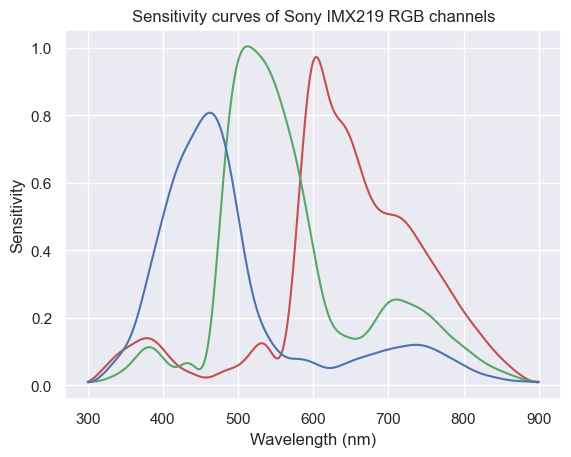

In [13]:
plt.title('Sensitivity curves of Sony IMX219 RGB channels')
plt.plot(imx219_wavelengths, imx219_rgb[:, 0], color='r')
plt.plot(imx219_wavelengths, imx219_rgb[:, 1], color='g')
plt.plot(imx219_wavelengths, imx219_rgb[:, 2], color='b')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Sensitivity')
plt.show()

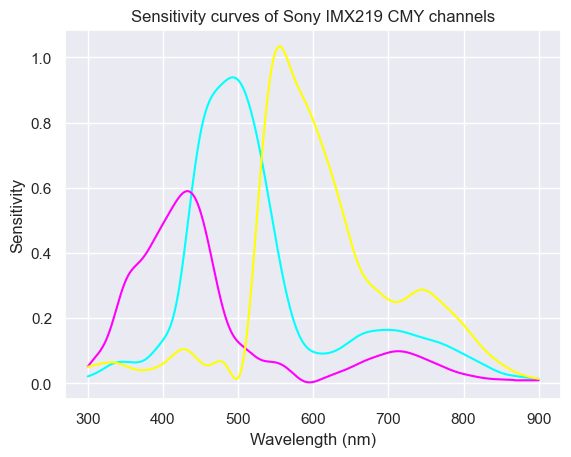

In [14]:
plt.title('Sensitivity curves of Sony IMX219 CMY channels')
plt.plot(imx219_wavelengths, imx219_cmy[:, 0], color='cyan')
plt.plot(imx219_wavelengths, imx219_cmy[:, 1], color='magenta')
plt.plot(imx219_wavelengths, imx219_cmy[:, 2], color='yellow')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Sensitivity')
plt.show()

Next, we clip the sensitivity curves to ensure that they are within range of the reference hyperspectral data.

In [15]:
imx219_wavelength_min = max(hsi_wavelengths.min(), imx219_wavelengths.min())
imx219_wavelength_max = min(hsi_wavelengths.max(), imx219_wavelengths.max())
imx219_wavelength_mask = ((imx219_wavelengths >= imx219_wavelength_min) &
                          (imx219_wavelengths <= imx219_wavelength_max))

In [16]:
imx219_wavelengths = imx219_wavelengths[imx219_wavelength_mask]
imx219_rgb = imx219_rgb[imx219_wavelength_mask]
imx219_cmy = imx219_cmy[imx219_wavelength_mask]

As a visual reference, we plot the clipped sensitivity curves.

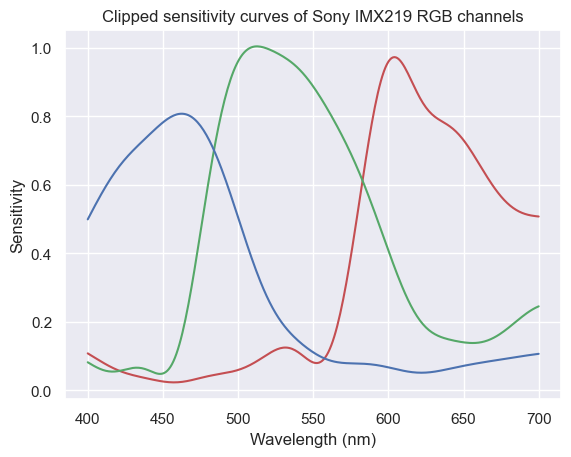

In [17]:
plt.title('Clipped sensitivity curves of Sony IMX219 RGB channels')
plt.plot(imx219_wavelengths, imx219_rgb[:, 0], color='r')
plt.plot(imx219_wavelengths, imx219_rgb[:, 1], color='g')
plt.plot(imx219_wavelengths, imx219_rgb[:, 2], color='b')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Sensitivity')
plt.show()

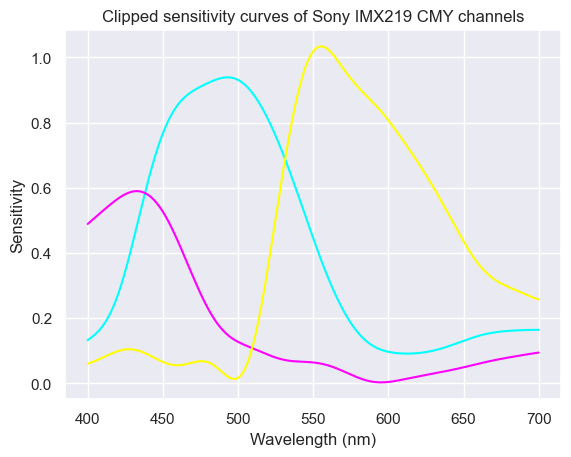

In [18]:
plt.title('Clipped sensitivity curves of Sony IMX219 CMY channels')
plt.plot(imx219_wavelengths, imx219_cmy[:, 0], color='cyan')
plt.plot(imx219_wavelengths, imx219_cmy[:, 1], color='magenta')
plt.plot(imx219_wavelengths, imx219_cmy[:, 2], color='yellow')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Sensitivity')
plt.show()

After synthesizing the RGB image, we want to ensure that all resulting channels are within the $[0, 1]$ range. To accomplish this, we normalize each sensitivity curve so that taking the integral between the product of the curve and the largest possible spectral samples (i.e., $1$) would result in a value $\le 1$ for each channel. To maintain the relative strengths of each curve, we scale them by the same largest factor.

In [19]:
imx219_rgb /= np.max(integrate.simpson(imx219_rgb, imx219_wavelengths, axis=0))
imx219_cmy /= np.max(integrate.simpson(imx219_cmy, imx219_wavelengths, axis=0))

As a visual reference, we plot the scaled sensitivity curves.

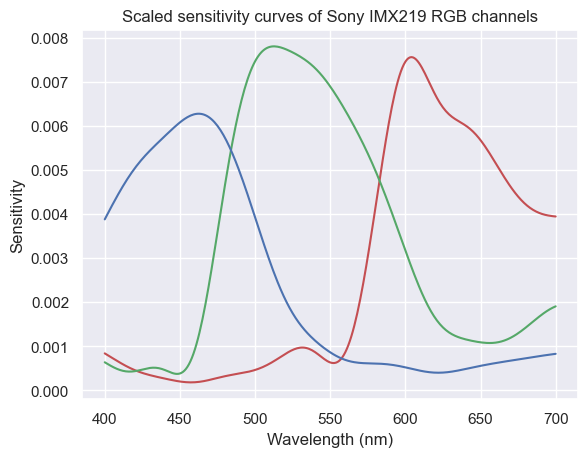

In [20]:
plt.title('Scaled sensitivity curves of Sony IMX219 RGB channels')
plt.plot(imx219_wavelengths, imx219_rgb[:, 0], color='r')
plt.plot(imx219_wavelengths, imx219_rgb[:, 1], color='g')
plt.plot(imx219_wavelengths, imx219_rgb[:, 2], color='b')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Sensitivity')
plt.show()

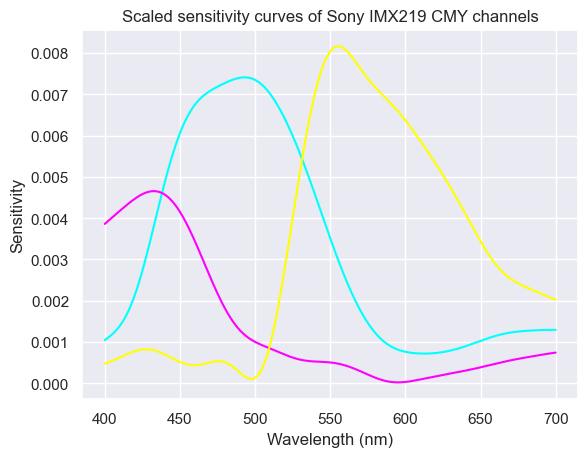

In [21]:
plt.title('Scaled sensitivity curves of Sony IMX219 CMY channels')
plt.plot(imx219_wavelengths, imx219_cmy[:, 0], color='cyan')
plt.plot(imx219_wavelengths, imx219_cmy[:, 1], color='magenta')
plt.plot(imx219_wavelengths, imx219_cmy[:, 2], color='yellow')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Sensitivity')
plt.show()

Furthermore, we must ensure that the hyperspectral samples are aligned with the sensitivity curves via interpolation. This way, we also upscale the spectral resolution of the hyperspectral image to increase accuracy.

In [22]:
hsi_splines = interpolate.CubicSpline(hsi_wavelengths, hsi.reshape(-1, bands).T)

In [23]:
hsi_imx219 = hsi_splines(imx219_wavelengths).T.reshape(height, width, -1)

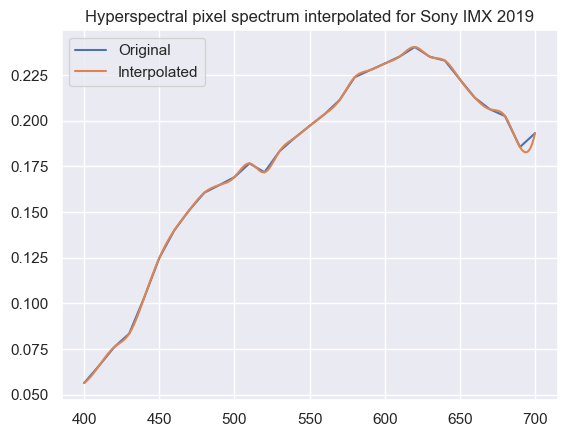

In [24]:
plt.title('Hyperspectral pixel spectrum interpolated for Sony IMX 2019')
plt.plot(hsi_wavelengths, hsi[500, 200], label='Original')
plt.plot(imx219_wavelengths, hsi_imx219[500, 200], label='Interpolated')
plt.legend()
plt.show()

For simplicity, we will compute RGB and CMY values separately using each channel's sensitivity curve.

In [25]:
imx219_r = imx219_rgb[:, 0]
imx219_g = imx219_rgb[:, 1]
imx219_b = imx219_rgb[:, 2]

In [26]:
imx219_c = imx219_cmy[:, 0]
imx219_m = imx219_cmy[:, 1]
imx219_y = imx219_cmy[:, 2]

Thus, the RGB and CMY values are given by the following integrals.

In [27]:
IMX_R = integrate.simpson(hsi_imx219 * imx219_r, imx219_wavelengths)
IMX_G = integrate.simpson(hsi_imx219 * imx219_g, imx219_wavelengths)
IMX_B = integrate.simpson(hsi_imx219 * imx219_b, imx219_wavelengths)
IMX_RGB = np.dstack((IMX_R, IMX_G, IMX_B))

In [28]:
IMX_C = integrate.simpson(hsi_imx219 * imx219_c, imx219_wavelengths)
IMX_M = integrate.simpson(hsi_imx219 * imx219_m, imx219_wavelengths)
IMX_Y = integrate.simpson(hsi_imx219 * imx219_y, imx219_wavelengths)
IMX_CMY = np.dstack((IMX_C, IMX_M, IMX_Y))

The following synthesized RGB and CMY images represent the raw sensor response of the Sony IMX219 camera, prior to any calibration or color correction. This data may now be used to train a camera-specific spectral reconstruction model.

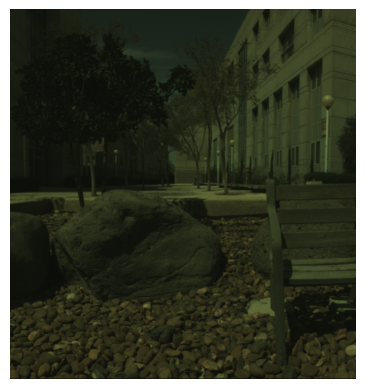

In [29]:
plt.axis('off')
plt.imshow(np.rot90(IMX_RGB));

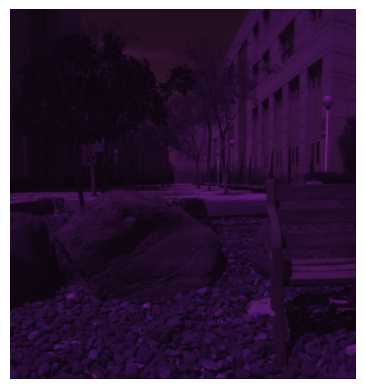

In [30]:
plt.axis('off')
plt.imshow(np.rot90(IMX_CMY));

To make the images look more realistic, we may normalize each channel independently through contrasting.

In [31]:
IMX_RGB_normalized = IMX_RGB.copy()
IMX_RGB_normalized -= IMX_RGB_normalized.min(axis=(0, 1), keepdims=True)
IMX_RGB_normalized /= IMX_RGB_normalized.max(axis=(0, 1), keepdims=True)

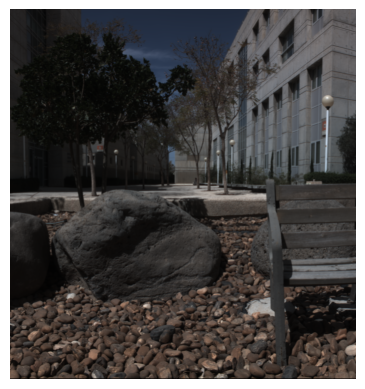

In [32]:
plt.axis('off')
plt.imshow(np.rot90(IMX_RGB_normalized));

In [33]:
IMX_CMY_normalized = IMX_CMY.copy()
IMX_CMY_normalized -= IMX_CMY_normalized.min(axis=(0, 1), keepdims=True)
IMX_CMY_normalized /= IMX_CMY_normalized.max(axis=(0, 1), keepdims=True)

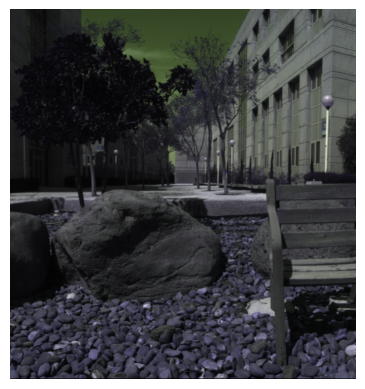

In [34]:
plt.axis('off')
plt.imshow(np.rot90(IMX_CMY_normalized));

## Synthesis using CIE XYZ CMF

For comparison, we will also use the CIE XYZ color-matching functions obtained experimentally in 1931 to simulate human vision. The sensitivity functions are provided in a CSV file as well.

In [35]:
cie_df = pd.read_csv('resources/CIE_XYZ_1931.csv')

Similarly to the previous data frame, the CMF consists of XYZ samples at specific wavelengths.

In [36]:
cie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Wavelength  89 non-null     int64  
 1   X           89 non-null     float64
 2   Y           89 non-null     float64
 3   Z           89 non-null     float64
dtypes: float64(3), int64(1)
memory usage: 2.9 KB


For convenience, we extract the wavelengths into a separate variable.

In [37]:
cie_wavelengths = cie_df['Wavelength'].values
cie_cmf = cie_df[['X', 'Y', 'Z']].values

We may now visualize the color-matching functions as well.

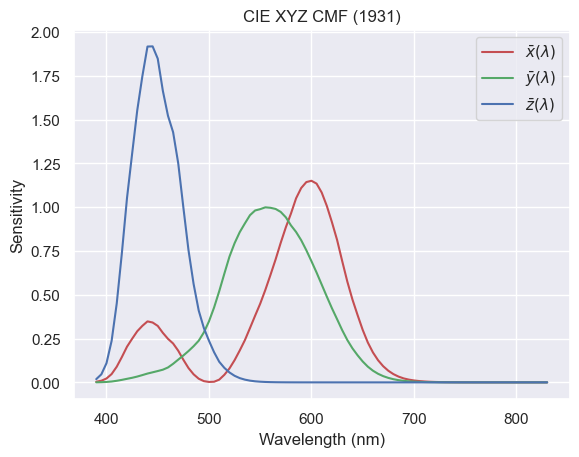

In [38]:
plt.title('CIE XYZ CMF (1931)')
plt.plot(cie_wavelengths, cie_cmf[:, 0], color='r')
plt.plot(cie_wavelengths, cie_cmf[:, 1], color='g')
plt.plot(cie_wavelengths, cie_cmf[:, 2], color='b')
plt.legend([
    r'$\bar{x}(\lambda)$',
    r'$\bar{y}(\lambda)$',
    r'$\bar{z}(\lambda)$',
])
plt.xlabel('Wavelength (nm)')
plt.ylabel('Sensitivity')
plt.show()

Yet again, we resample the curves to align them with the wavelengths of the hyperspectral image.

In [39]:
cie_wavelength_min = max(hsi_wavelengths.min(), cie_wavelengths.min())
cie_wavelength_max = min(hsi_wavelengths.max(), cie_wavelengths.max())
cie_wavelength_mask = ((cie_wavelengths >= cie_wavelength_min) &
                       (cie_wavelengths <= cie_wavelength_max))

In [40]:
cie_wavelengths = cie_wavelengths[cie_wavelength_mask]
cie_cmf = cie_cmf[cie_wavelength_mask]

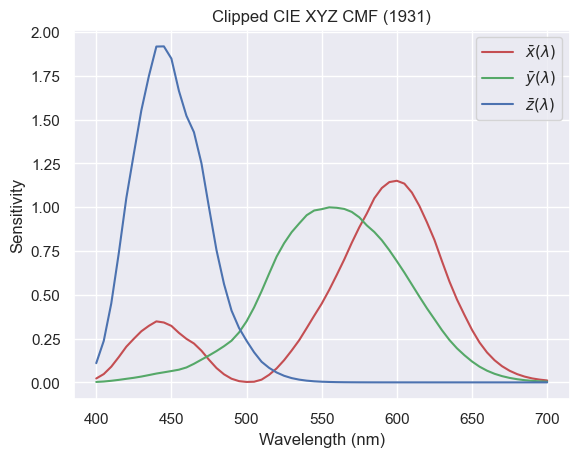

In [41]:
plt.title('Clipped CIE XYZ CMF (1931)')
plt.plot(cie_wavelengths, cie_cmf[:, 0], color='r')
plt.plot(cie_wavelengths, cie_cmf[:, 1], color='g')
plt.plot(cie_wavelengths, cie_cmf[:, 2], color='b')
plt.legend([
    r'$\bar{x}(\lambda)$',
    r'$\bar{y}(\lambda)$',
    r'$\bar{z}(\lambda)$',
])
plt.xlabel('Wavelength (nm)')
plt.ylabel('Sensitivity')
plt.show()

In [42]:
cie_cmf /= np.max(integrate.simpson(cie_cmf, cie_wavelengths, axis=0))

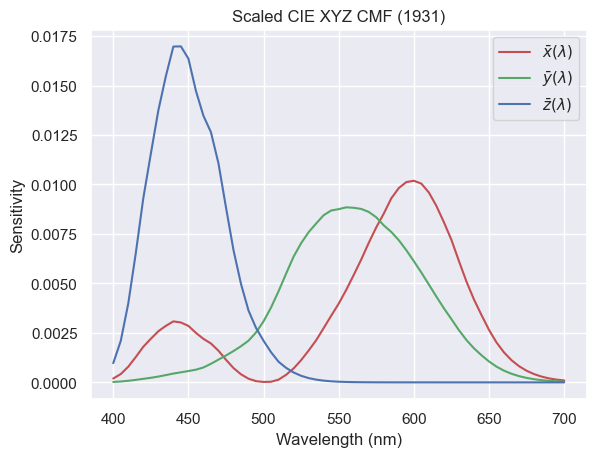

In [43]:
plt.title('Scaled CIE XYZ CMF (1931)')
plt.plot(cie_wavelengths, cie_cmf[:, 0], color='r')
plt.plot(cie_wavelengths, cie_cmf[:, 1], color='g')
plt.plot(cie_wavelengths, cie_cmf[:, 2], color='b')
plt.legend([
    r'$\bar{x}(\lambda)$',
    r'$\bar{y}(\lambda)$',
    r'$\bar{z}(\lambda)$',
])
plt.xlabel('Wavelength (nm)')
plt.ylabel('Sensitivity')
plt.show()

In [44]:
hsi_aligned_cie = hsi_splines(cie_wavelengths).T.reshape(height, width, -1)

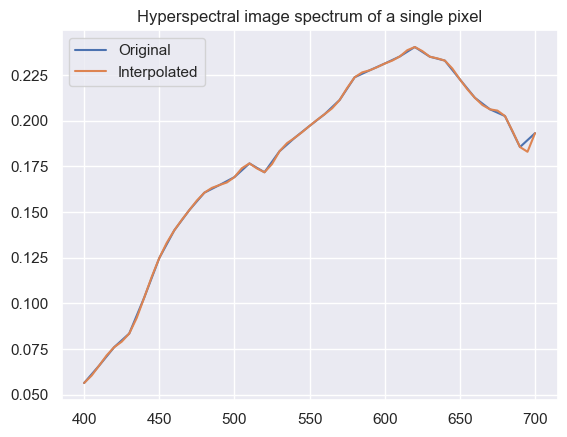

In [45]:
plt.title('Hyperspectral image spectrum of a single pixel')
plt.plot(hsi_wavelengths, hsi[500, 200], label='Original')
plt.plot(cie_wavelengths, hsi_aligned_cie[500, 200], label='Interpolated')
plt.legend()
plt.show()

In [46]:
cmf_x = cie_cmf[:, 0]
cmf_y = cie_cmf[:, 1]
cmf_z = cie_cmf[:, 2]

In [47]:
CIE_X = integrate.simpson(hsi_aligned_cie * cmf_x, cie_wavelengths)
CIE_Y = integrate.simpson(hsi_aligned_cie * cmf_y, cie_wavelengths)
CIE_Z = integrate.simpson(hsi_aligned_cie * cmf_z, cie_wavelengths)
CIE_XYZ = np.dstack((CIE_X, CIE_Y, CIE_Z))

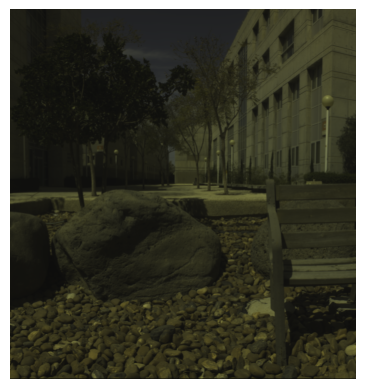

In [48]:
plt.axis('off')
plt.imshow(np.rot90(CIE_XYZ));

In [49]:
M = np.array([
    [+3.2404542, -1.5371385, -0.4985314],
    [-0.9692660, +1.8760108, +0.0415560],
    [+0.0556434, -0.2040259, +1.0572252],
])

In [50]:
CIE_sRGB = M @ CIE_XYZ.reshape(-1, 3).T

In [51]:
CIE_sRGB -= CIE_sRGB.min(axis=1, keepdims=True)
CIE_sRGB /= CIE_sRGB.max(axis=1, keepdims=True)

In [52]:
CIE_RGB = CIE_sRGB.T.reshape(height, width, 3)

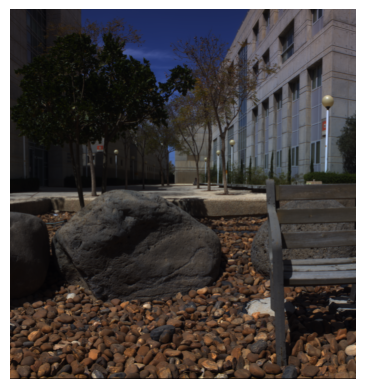

In [53]:
plt.axis('off')
plt.imshow(np.rot90(CIE_RGB));

In [54]:
gamma_map = CIE_sRGB <= 0.0031308
CIE_sRGB[ gamma_map] = 12.92 * CIE_sRGB[ gamma_map]
CIE_sRGB[~gamma_map] = 1.055 * CIE_sRGB[~gamma_map]**0.416 - 0.055

In [55]:
CIE_R = np.reshape(CIE_sRGB[0], (height, width))
CIE_G = np.reshape(CIE_sRGB[1], (height, width))
CIE_B = np.reshape(CIE_sRGB[2], (height, width))
CIE_RGB = np.dstack((CIE_R, CIE_G, CIE_B))

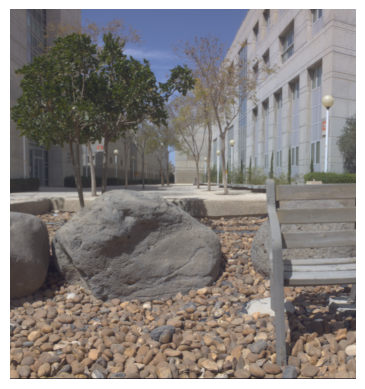

In [56]:
plt.axis('off')
plt.imshow(np.rot90(CIE_RGB));